# 12 機械学習の基礎（教師なし学習）

- **[12.1 クラスタリング(クラスター分析）](#12.1-クラスタリング(クラスター分析）)** 
<br><br>
- **[12.2 次元圧縮（主成分分析）](#12.2-次元圧縮（主成分分析）)** 
<br><br>
- **[12.3 バスケット分析とアソシエーションルール](#12.3-バスケット分析とアソシエーションルール)** 
<br><br>
- **[12.4 総合問題](#12.4-総合問題)**
    - [12.4.1 総合問題1](#12.4.1-総合問題1)
    - [12.4.2 総合問題2](#12.4.2-総合問題2)

In [1]:
# 途中で使用するため、あらかじめ読み込んでおいてください。
# データ加工・処理・分析モジュール
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化モジュール
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習モジュール
import sklearn

# 小数第３まで表示
%precision 3

'%.3f'

## 12.1 クラスタリング(クラスター分析）
キーワード：k-means、k-means++、エルボー法、非階層型、階層型

ここから、教師なし学習について学びましょう。教師なし学習は、教師あり学習と異なり、アウトプット（Y）やゴールが与えられず、インプットのデータだけを使って、インサイトを見つけ出す方法でした。つまり予測すべきターゲット変数がありません。答えがわかっていない状態で、データの隠れた構造を見つけ出す手法が教師なし学習です。前にも触れました通り、人間的な解釈が必要な場面も多く、探索的なデータ分析だと言えるでしょう。まずは、簡単な数値例からクラスタリングを実施していきましょう。（なお、クラスタリングはクラスター分析とも言います。）

ここでは、よくクラスタリングで使われる**k-means**法について取り扱っていきます。具体的には、以下のような図を参考に、ある属性データ（収入、借入れなど）が与えられて、顧客を3つのグループに分けることを考えます。以下の平面の中からどこでも良いので、ランダムに3つ点を取ります。それぞれの点をクラスター1、クラスター2、クラスター3とします。そして、それぞれの点データについて、3つのクラスターの中から一番近い点を選び、それを自身のクラスター番号とします。すべてのデータについてクラスター番号が決まった後は、それぞれのクラスターの重心（平均）を計算します。その3つの点を再びクラスターの番号として、データがその3点の中で一番近い点を選び、これを繰り返していきます。この中心点が動かなくなったら、そこで終了になります。これがk-meansです。（なお、後で紹介するEMアルゴリズム(期待値ステップと最大化ステップの繰り返し)と関係があります。）

以下の参照URLはイメージです。

![comment](http://insidebigdata.com/wp-content/uploads/2013/12/Clustering.gif)

参照URL：http://insidebigdata.com/wp-content/uploads/2013/12/Clustering.gif

アルゴリズムは上の説明だけだとなかなかイメージしにくいと思いますので、以下のURLを参考にしてみてください。

参考URL：http://tech.nitoyon.com/ja/blog/2013/11/07/k-means/

なお、k-meansはKMean関数を使いますが、以下で設定しているパラメータ（init='random'）を省略すると**k-means++**になります。k-means++は、k-meansで初期値で設定する値をなるべく広げて取るように計算する手法で、k-meansよりも安定的な結果が得られます。k-meansは先ほど見たように、初めに取る点をランダムに選択するので、その影響で偏りが生じる可能性があり、その解決を試みたのがk-means++です。

他には、上のようにセントロイド（平均）ではなく、medoid（中央値）を計算する方法**k-medoids法**などもあります。これは、k-means法のように中心点が架空の数値をとることはなく、実在する点をとります。外れ値による影響が少ないことがこの方法のメリットです。

これらの手法について興味のある方や実際に実装する機会がある方は、調べてみてください。

>**[やってみよう]**

>k-means、k-means++、k-medoidsについて調べてみましょう。それぞれのメリット、デメリットや実装方法などについて調べてみましょう。

では、サンプルとしてk-meansを実行してみましょう。データはsklearnにあるmake_blobsのデータを使います。

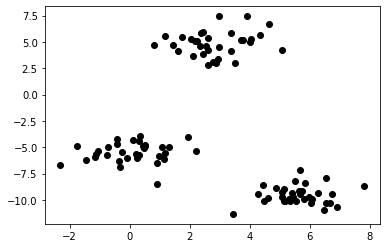

In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X,y = make_blobs(random_state=10)

plt.scatter(X[:,0],X[:,1],color='black')

関数はKMeansを使います。initをrandom、n_clusters=3と設定しています。3はクラスター数といい、グループの数です。

In [3]:
kmeans = KMeans(init='random',n_clusters=3)
kmeans.fit(X)

y_pre = kmeans.fit_predict(X)

上の図から、どのようにグループ（クラスター）ができるかは予想できそうですが、先ほどのk-meansの結果をグラフ化してみましょう。それぞれのインスタンス（データの1行に値するもの、人の属性データなら一人分のデータ）にクラスター番号が付与されます。ここでもpandasのテクニックを使います。

In [4]:
# 順にx座標、y座標、cluster番号のデータを横に結合するためconcatでaxis=1を指定しています。
merge_data = pd.concat([pd.DataFrame(X[:,0]),pd.DataFrame(X[:,1]),pd.DataFrame(y_pre)]
                       ,axis=1)


# elementが属性、clusterがクラスター番号
merge_data.columns = ["element1","element2","cluster"]

グラフ化するために、グループごとにデータを分けることにします。例えば、クラスター0のグループはmerge_data_cluster0とします。

In [5]:
merge_data_cluster0 = merge_data[merge_data["cluster"]==0]
merge_data_cluster1 = merge_data[merge_data["cluster"]==1]
merge_data_cluster2 = merge_data[merge_data["cluster"]==2]

次に、実際にそれぞれのグループデータで、x軸をelement1、y軸をelement2として、色をそれぞれ分けて図示すると以下のようになります。

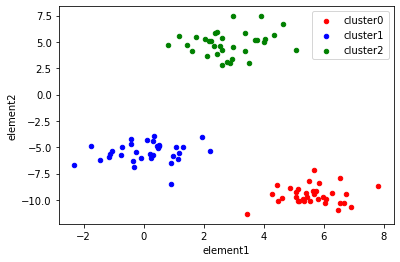

In [6]:
ax =merge_data_cluster0.plot.scatter(x='element1', y='element2', color='red', label='cluster0');
merge_data_cluster1.plot.scatter(x='element1', y='element2', color='blue', label='cluster1',ax=ax);
merge_data_cluster2.plot.scatter(x='element1', y='element2', color='green', label='cluster2',ax=ax);

上の図を見ていただくとわかるように、クラスター分析を実施することで、綺麗に3つのグループに分かれることがわかります。

さて次に、このクラスタリングの結果を一体どうやって活用していくのか、実際のマーケティングのデータを使って見ていきましょう。

次に扱うデータは、ある金融機関のデータで、お客さんが定期預金の申し込みをしたかどうかのデータです。このデータには、キャンペーンの実施状況、お客さんの属性情報などいろいろデータがあります。このデータをクライアントから受け取って、「そもそも私たちにどんなお客さんがいるのかわからないので分析してほしい」というお題をいただいたとしましょう。

教師あり学習アプローチを考えるならば、定期預金をしたかどうかを目的変数にしてモデルを構築したいところですが、今回のように、何か目標となる変数がはっきりしないというケースはビジネスでは多々あります。このような場合や、データの中から潜在的な構造を見つけ出すために、教師なし学習のクラスタリングを実施してみるのも手でしょう。

まずは、対象データを読み込みます。(また、あらかじめディレクトリを作成し、そこへ移動しておきましょう。)

In [7]:
# webからデータを取得したり、zipファイルを扱うためのモジュール
import requests, zipfile
from io import StringIO
import io

# データがあるurl の指定
zip_file_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"

# データを取得して展開する
r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

データの確認をします。対象となるデータは、bank-full.csvになりますので、それを読み込みます。今回も区切りは「;」なので、気をつけてください。

In [8]:
banking_c_data = pd.read_csv("bank-full.csv",sep=";")
banking_c_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


参考ですが、以下が属性データです。inputが説明変数となるデータ、outputが目的変数となるデータになりますが、はじめは、目的変数を予測するかどうかは意識しないでおきましょう。

-Input variables:
- ##### bank client data:
1 - age (numeric)   
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)  
4 - education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5 - default: has credit in default? (categorical: 'no','yes','unknown')  
6 - housing: has housing loan? (categorical: 'no','yes','unknown')  
7 - loan: has personal loan? (categorical: 'no','yes','unknown')  
- ##### related with the last contact of the current campaign:   
8 - contact: contact communication type (categorical: 'cellular','telephone')   
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  

- ##### other attributes:  
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
14 - previous: number of contacts performed before this campaign and for this client (numeric)  
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')  
- ##### social and economic context attributes  
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
17 - cons.price.idx: consumer price index - monthly indicator (numeric)   
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)   
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
20 - nr.employed: number of employees - quarterly indicator (numeric)  

-Output variable (desired target):  
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')  

以下よりデータは約4.5万レコードあることがわかります。Unknownはありますが、Nullなどはないようです。

In [9]:
banking_c_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


まずは、変数として、age、balance、campaign、previousを使います。

In [10]:
banking_c_data_sub=banking_c_data[['age','balance','campaign','previous']]

ここで、各変数を見てみると単位もスケールも違うので、教師あり学習でやったスケーリングを同様に実施しましょう。こうすることで大きな変数に引っ張られずに済みます。

In [11]:
# 標準化のためのモジュール
from sklearn.preprocessing import StandardScaler

# 標準化
sc = StandardScaler()
sc.fit(banking_c_data_sub)
banking_c_data_sub_std = sc.transform(banking_c_data_sub)

それでは、k-meansを実施します。今回、クラスター数は6にするため、n_clusters=6とします。（クラスターの数を決めるときに、絶対的なルールはありませんが、後でその数を決める方法について述べます。）

In [12]:
from sklearn.cluster import KMeans

X = banking_c_data_sub_std

# random_state固定
kmeans = KMeans(init='random',n_clusters=6,random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=6,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)

k-meansを実行した後は、そのクラスター番号を取得するため、labels属性を取得しましょう。クラスター番号の列として、cl_nmを定めます。

In [13]:
labels = kmeans.labels_
label_data = pd.DataFrame(labels,columns=["cl_nm"])

ここで、各クラスターに割り当てられた人数を集計してみましょう。

In [14]:
label_data_bycl = label_data.groupby("cl_nm").size()
label_data_bycl

cl_nm
0    14411
1    23608
2     3837
3     1373
4     1282
5      700
dtype: int64

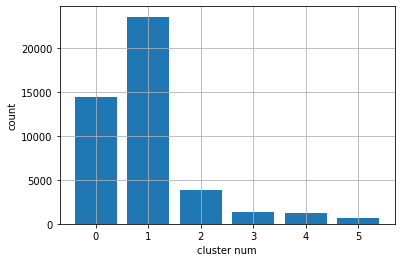

In [15]:
# 縦棒グラフ
plt.bar([0,1,2,3,4,5],label_data_bycl.values)

# それぞれのラベル
plt.ylabel("count")
plt.xlabel("cluster num")

# グリッドをつける
plt.grid(True)

バランスが悪く見えますが、このまま進めます。ここで問題になるのがクラスター数をどれくらいにすれば良いのかということです。先ほどはいきなり6で決め打ちしましたが、ここでは**エルボー法**という手法を用いて、クラスター内の歪みを見ながら決める方法を実施します。クラスターを増やしていくことでクラスター内の歪みは単調に減少しますが、本来ないクラスターを導入した場合は歪みの減少が小さくなることが考えられます。つまりクラスター数を歪みの減少が小さくなる直前に設定することで理想のクラスタ数を得ることができます。歪みの減少が急激に小さくなると、折れ線グラフはひじのような形になるためこのように命名されました。

以下では、クラスター数を変えながら、inertia_を取得します。

In [16]:
# エルボー法
dist_list =[]
for i in range(1,20):
    kmpp = KMeans(n_clusters=i,init='random',n_init=5,max_iter=100,random_state=0)
    kmpp.fit(X)
    dist_list.append(kmpp.inertia_)

次のグラフはクラスター数を変えながらDistortionの値を見ています。以下の結果は若干微妙ですが、クラスター数が5〜6付近でエルボーのようになっているため、6でも良さそうです。

Text(0, 0.5, 'Distortion')

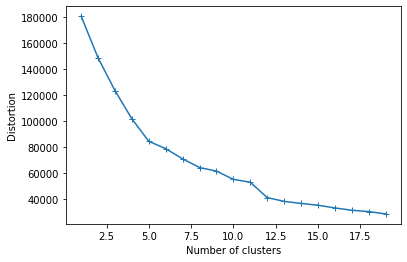

In [17]:
plt.plot(range(1,20),dist_list,marker='+')
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")

クラスター数を決定する他の方法として、**シルエット分析(シルエット係数)**などもありますので、興味のある方は参考文献などを見て調べてみてください。

>**[やってみよう]**

>シルエット分析とはなんでしょうか。調べてみましょう。

さて、実務的にはこのクラスタリングの結果を解釈していくことが大事になってきますが、ほとんどの機械学習の本にはそこについて触れられていません。クラスタリングはグループ分けをしたら終わりではなく、そこのグループが一体どんなグループなのか、それがわかって次にどんなアクションが取れるのかを求められます。ここでは、その前段階として、クラスタリングをどのように解釈していくか、少し深堀していきましょう。

まず、先ほどのクラスター番号を、元あったデータに紐づけます。

In [26]:
merge_data = pd.concat([banking_c_data,label_data],axis=1)

In [27]:
merge_data.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cl_nm
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,4
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,4
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0


次に、例えば、クラスターのそれぞれの年齢層はどうなるかということが気になると思います。以下は、pandasで学んだ分割と、ピボットテーブルを使います。軸はクラスター番号と、年齢です。年齢は基本的に15歳から5歳区切りで、最後は65歳以上100歳未満で区切っています。このようなところでもpandasで学んだテクニックが使えます。

In [28]:
#　分割の粒度
absences_bins = [15,20,25,30,35,40,45,50,55,60,65,100]
qcut_result = pd.cut(merge_data.age,absences_bins,right=False)
value_qcut_result = pd.value_counts(qcut_result)
value_qcut_result

[30, 35)     9740
[35, 40)     8349
[40, 45)     6185
[45, 50)     5470
[50, 55)     4488
[25, 30)     4464
[55, 60)     3922
[60, 65)      974
[65, 100)     810
[20, 25)      762
[15, 20)       47
Name: age, dtype: int64

In [29]:
merge_data_age_cl = pd.concat([merge_data.cl_nm,qcut_result],axis=1)

以下の表はクロス表になります。（行がクラスター番号、列が年齢区切りです。）

In [30]:
cluster_num_age_cross_tb = pd.pivot_table(merge_data_age_cl
                                          , index=['cl_nm'], columns=['age'],aggfunc=lambda x : len(x)
                                          ,fill_value = 0) 
cluster_num_age_cross_tb

age,"[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 100)"
cl_nm,,,,,,,,,,,
0,45,711,4024,8492,7146,4091,0,0,0,0,0
1,0,3,10,37,25,26,27,30,38,11,14
2,0,14,152,497,517,460,375,306,263,63,37
3,0,20,132,327,308,187,146,117,71,38,34
4,0,0,0,0,0,1155,4701,3885,3436,838,719
5,2,14,146,387,353,266,221,150,114,24,6


ただ、人数だけではわからないので、上の表をベースに、クラスター内においてどの年齢層の割合を計算して、グラフ化しているのが以下になります。

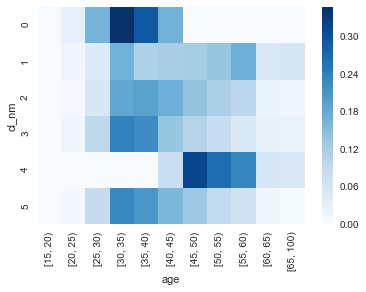

In [32]:
sns.heatmap(cluster_num_age_cross_tb.apply(lambda x : x/sum(x), axis=1),cmap="Blues")

上記を見ていると、クラスター番号0の年齢層が30-40前後で固まっている一方で、クラスター番号4は45-50前後に固まっていることがわかります。

次は、jobについて見てみましょう。

In [33]:
merge_data_job_cl = merge_data[['cl_nm','job']]

In [34]:
cluster_num_job_cross_tb = pd.pivot_table(merge_data_job_cl
                                          , index=['cl_nm'], columns=['job'],aggfunc=lambda x : len(x)
                                          ,fill_value = 0) 
cluster_num_job_cross_tb

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
cl_nm,,,,,,,,,,,,
0,3097,5610,728,426,5130,57,852,2564,813,4459,698,75
1,15,12,19,7,91,24,11,9,3,21,6,3
2,219,459,91,70,788,111,130,189,48,460,99,20
3,196,244,42,22,332,53,41,112,52,250,31,5
4,1467,3040,543,675,2732,1984,479,1124,4,2084,439,163
5,177,367,64,40,385,35,66,156,18,323,30,22


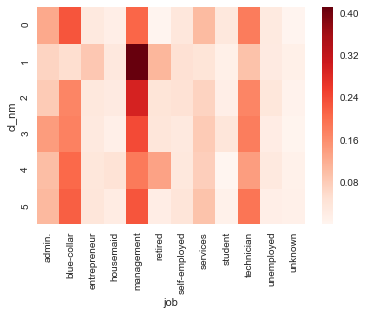

In [37]:
sns.heatmap(cluster_num_job_cross_tb.apply(lambda x : x/sum(x), axis=1),cmap="Reds")

上記を見ていると、クラスター番号1が特にマネジメント層の割合が多いのがわかります。一方、クラスタ番号0や4、5はブルーカラー割合が若干多いようです。

まだ他の軸を見る必要などありますが、例えばクラスターの解釈として、クラスター番号0は年齢が30〜40歳が多くブルーカラーの人が多いなどわかってきていますので、ある程度どんな人物なのか浮かび上がってきます（クラスター分析はユーザーの人物像を描くための**ペルソナ分析**にも使われたりします。）。このようにクラスタリングを実施し、顧客を色々な視点からセグメンテーションすることで、そのグループにあった提案やサービス戦略を考える材料になります。

以上で、教師なし学習のクラスタリングは終わりです。なお今回のクラスタリングは、**非階層型**といわれるクラスタリングを実施してきました。他、**階層型**のクラスタリングもあります。階層型は計算はsklearn.clusterのAgglomerativeClusteringを使います。ここでは詳細は述べませんが、興味のある方は参考文献などをみてください。実務的には、階層型のクラスタリングの方が理解しやすいかもしれません。

他には確率的にグループ所属を決める**ソフトクラスタリング**があります。今までのアプローチは**ハードクラスタリング**といい、それぞれのユーザーに付くクラスター番号は一意でしたが、ソフトクラスタリングは確率的にグループに属するという考え方です。これは現実にも考えられることで、ある人はグループ1にも属するかもしれないしグループ2に属するかもしれないので、それぞれのグループに所属する確率を求めることは理にかなっていると言えます。これもここでは実装しませんが、興味がある方はぜひ調べてみてください。

>**[やってみよう]**

>上の階層型、非階層型のクラスタリングについて調べてみましょう。また、ソフトクラスタリングやハードクラスタリングの違いやそのアプローチについて調べて、実装してみましょう。

####  <練習問題 1>
先ほど扱ったmake_blobsデータに対して、random_state=52にしてデータをグラフ化してみましょう。そこからクラスター分析をしてください。いくつのグループに分けますか。また分けた後は、クラスター番号がわかるように色分けして、グラフ化してください。

####  <練習問題 2>
先ほど扱ったデータbanking_c_data_subに対して、クラスター数を4にしてクラスター分析を実行した場合(k-means)に、どのような結果になりますか？先ほどと同じようにクラスター番号を取得した後は、それぞれのクラスターがどのようなグループになっているか深堀分析をして、それぞれのグループのペルソナ（顧客像）を考えましょう。またクラスター数を8にした場合はどうでしょうか。さらに、age、balance、campaign、previous以外の変数を選んだ場合はどうでしょうか。使う変数を選んで、同じようにクラスター分析を実行して、その結果を深掘りし、考察してください。

## 12.2 次元圧縮（主成分分析）
キーワード：PCA

次は、次元圧縮です。教師あり学習（判別分析）もありますが、ここでは教師なし次元圧縮の主成分分析について学びましょう。

これまで見てきた通り、データには様々な種類があります。例えば先ほどの金融マーケティングのデータでは、職業だったり、年齢など色々な変数がありました。これらの変数と目的変数との関係性を1つ1つ見ていくことも大切ですが、人の目では確認できない量だったり、それぞれの変数間の関係性なども考慮してみるとなると、どのように見ていけばいいのかわからなくなることもあるでしょう。ここで、主成分分析を実施することで、データの情報をできるだけ失わずに、データを圧縮する（変数の種類を減らす）ことができます。要は、たくさん変数がある場合に、それらの情報をなるべく落とさないようにして、扱う変数を減らすのが次元圧縮です。

まずは、簡単なサンプルデータからその方法を見てみましょう。以下は、2変数のデータ（乱数、シード固定）をプロットした図です。

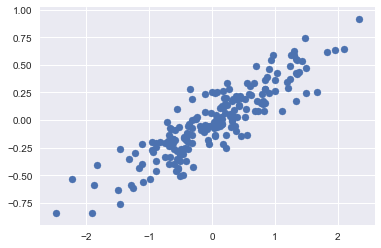

In [38]:
rng_data = np.random.RandomState(1)
X = np.dot(rng_data.rand(2, 2), rng_data.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])

主成分分析はfrom sklearn.decomposition import PCAとして、以下ではパラメータ（作成する主成分/Principal Componentの数）を2に設定しています。次元圧縮なので、通常は元の変数の数より小さい値を設定しますが、ここでは手法の説明のため2とします。

pca.fit()でPCAの計算を実施しています。

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

以下は、その実際の計算結果になります。2つ取り出されているのがわかります。

In [40]:
print(pca.components_)
print(pca.explained_variance_)

[[-0.944 -0.329]
 [-0.329  0.944]]
[ 0.759  0.018]


数字だけではわかりにくいので、図示してみましょう。以下の矢印が主成分分析の結果の数値になります。分散が最大になるように、お互いに直角になるようにしています。元のグラフについて、新しく軸を設定するイメージです。

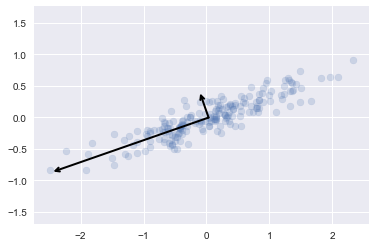

In [41]:
# パラメータ設定
arrowprops=dict(arrowstyle='->',
                linewidth=2,
                shrinkA=0, 
                shrinkB=0)

# 矢印を描くための関数
def draw_vector(v0, v1, ax=None):
    plt.gca().annotate('', v1, v0, arrowprops=arrowprops)

# 元のデータをプロット
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)

# 主成分分析の2軸を矢印で表示する
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)

plt.axis('equal');

>[参照URL]  

>https://github.com/jakevdp/PythonDataScienceHandbook

図を見て分かるとおり、元の散布図に対して分散が最大になるよう第1成分が作成され、それに直交する形で第2成分が作成されます。元の各点から第1成分に垂線を下ろした点を考えると、元の2変数が1変数に次元削除されたことになります。

ちなみに、詳細な説明は省きますが、途中の計算には線形代数における固有値や固有ベクトルの概念を使います。この講座でもScipyなどを使って固有値の計算等を扱いました。これらを理解すると、機械学習を勉強していくうえで後々便利でしょう。

もう少し、次元圧縮のイメージを理解するために例を見ていきましょう。以下の参照図は3Dで見たときのグラフで、それぞれのプロットで色が分けられています。この3次元のデータを、持っている情報をなるべく落とさずに、圧縮します。

![](https://sebastianraschka.com/images/blog/2014/kernel_pca/2014-09-14-kernel_pca_87_0.png)
参照URL:http://sebastianraschka.com/Articles/2014_kernel_pca.html

先ほどの3次元データを圧縮して2次元に減らすと、次のグラフのようになります。PC1が第1主成分、PC2が第2主成分の値となります。

![](https://sebastianraschka.com/images/blog/2014/kernel_pca/2014-09-14-kernel_pca_91_0.png)
参照URL:http://sebastianraschka.com/Articles/2014_kernel_pca.html

上のような図を見ていただくとわかる通り、それぞれの色もある程度かたまって、それぞれの点が2次元のグラフで表現されています。

さて、主成分分析の概念とイメージは、上記のようになります。では、この主成分分析を使って次元を圧縮することで、具体的にどのような場面で役に立つのでしょうか。確かに、情報は落とさずに次元を減らすと、データとして扱いやすくはなりそうです。そこで以前問題で扱ったcancerデータを使って、主成分分析の有用性を見ていただくことにします。

以下は、cancerの目的変数（cancer.target）において、malignant（悪性）とbenign（良性）がそれぞれの属性でどのような分布になっているかのヒストグラムです。ほとんどのグラフについては、malignantとbenignのデータが重なっており、このままですと、悪性か良性かを見分けるのにどこに境界線（境界値）を引いていいのか難しい状況です。

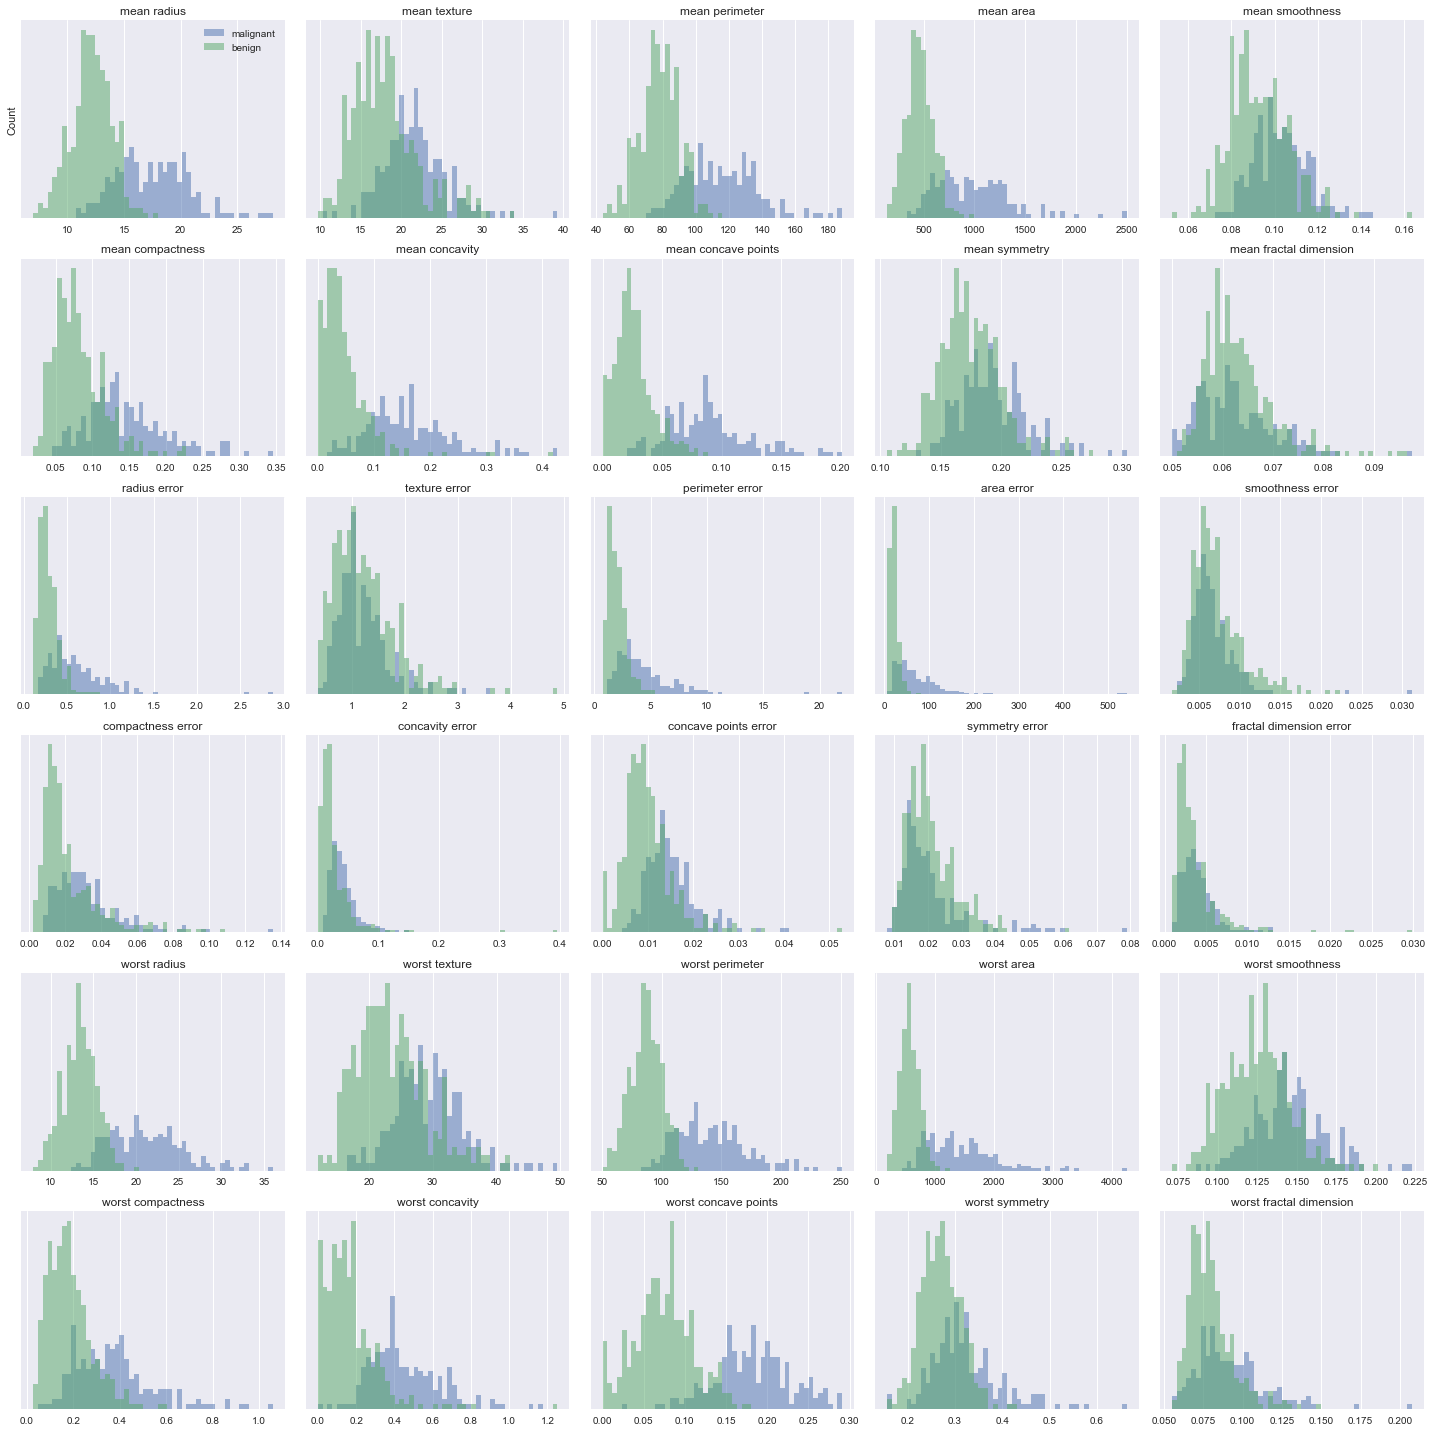

In [42]:
from sklearn.datasets import load_breast_cancer

# ガンのデータ
cancer = load_breast_cancer()

# 悪性
malignant = cancer.data[cancer.target==0]

# 良性
benign = cancer.data[cancer.target==1]

# グラフを分割するための準備
fig, axes = plt.subplots(6,5,figsize=(20,20))
ax = axes.ravel()
for i in range(30):
    _,bins = np.histogram(cancer.data[:,i],bins=50)
    ax[i].hist(malignant[:,i],bins=bins,alpha=.5)
    ax[i].hist(benign[:,i],bins=bins,alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
    
# ラベルの設定
ax[0].set_ylabel("Count")
ax[0].legend(["malignant","benign"],loc="best")
fig.tight_layout()

>[参照文献]  

>『Introduction to Machine Learning with Python』（Andreas C.Muller & Sarah Guido、O'REILLY）

ここで主成分分析を使って、これらの20個以上ある変数を凝縮してみることにします。まずは、説明変数となるデータのみ対象として、データのスケーリングを実施し、主成分分析をかけます。目的変数はない状態での分析になりますので、もちろん教師なし学習のアプローチです。これらのデータには答え（悪性か良性かのデータ）は入っていません。

作成する成分数（n_component）は2としておきます。たくさんある変数を2つの変数に凝縮します。

In [43]:
# 標準化のためのモジュール
from sklearn.preprocessing import StandardScaler

# 対象データ
from sklearn.datasets import load_breast_cancer

# PCA
from sklearn.decomposition import PCA

cancer = load_breast_cancer()

sc = StandardScaler()
sc.fit(cancer.data)
X_scaled = sc.transform(cancer.data)

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

上記で、第1成分と第2成分のデータが生成されましたので、次にそれらに対応する目的変数（cancer.targetにあり悪性か良性か）のデータフレームワークをくっつけて、データを作成してみましょう。

In [44]:
# 第1成分と第2成分、ターゲット変数をマージする
merge_data = pd.concat([pd.DataFrame(X_pca[:,0]),pd.DataFrame(X_pca[:,1]),pd.DataFrame(cancer.target)]
                       ,axis=1)
merge_data.columns = ["first","second","target"]

In [45]:
# 悪性、良性を分ける
merge_data_malignant = merge_data[merge_data["target"]==0]
merge_data_benign = merge_data[merge_data["target"]==1]

次にこのデータをプロットして、ラベルとして赤がmalignant（悪性）、青がbenign（良性）とすると、以下のような図になります。

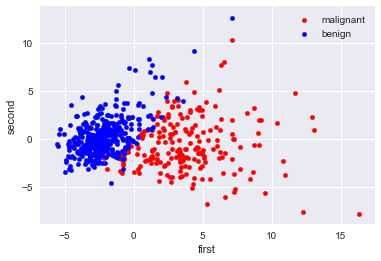

In [46]:
ax =merge_data_malignant.plot.scatter(x='first', y='second', color='red', label='malignant');
merge_data_benign.plot.scatter(x='first', y='second', color='blue', label='benign',ax=ax);

いかがでしょうか。良性と悪性がほぼきれいに分かれていることがわかります。データを圧縮するときには、特に答えは教えていません（良性か悪性かのデータを入れていません）でした。データの変数が多くて、どの変数を選んだらいいかわからない場合は、この主成分分析をしてみるのも良いでしょう。

####  <練習問題 1>
前章の機械学習（教師あり学習）の総合問題でも扱ったsklearnのdatasetsからload_iris(アヤメの花)を読み込んで、iris.dataを対象にPCA（n_componentsは2）を実行してください。またPCAの第2成分までのデータと、目的変数（iris.target）との関係性はどうでしょうか。グラフ化してみるなどして、考察してください。

## 12.3 バスケット分析とアソシエーションルール
キーワード：アソシエーションルール、支持度、確信度、リフト値

さて、次の教師なしの例は、購買データを対象とした分析手法です。

データベースの章でも購買データの集計を実施しました。購買データは、コンビニやスーパーマーケットなどのレジで収集される消費者行動のデータですが、よく例として取り上げられるのが、オムツとビールの購買の組み合わせです。ある家族のお父さんがオムツを買うときについでにビールを買うという話だったり、これは都市伝説だという指摘もありますが、消費者がどんな商品の組み合わせで買うのかは、消費財メーカーもスーパーなどのリテールも関心が高い問題です。

ここでは、以前、pandasの章の総合問題で使った購買データを使います。データの加工方法も途中まで同じです。

In [45]:
import pandas as pd

file_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
online_retail_data = pd.ExcelFile(file_url)

# シートを指定する
online_retail_data_table = online_retail_data.parse('Online Retail')
online_retail_data_table.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


参考ですが、読み込みに時間がかかりますので、あらかじめダウンロードして、それを読み込むようにコーディングしておくことをお勧めします。

In [ ]:
# 参考(処理としては上と同じ)
import requests

resp = requests.get(file_url)

#onlineRetail.xlsというファイル名で作成
output = open("onlineRetail.xls", 'wb')
output.write(resp.content)
output.close()

# 以下、上と同じ
online_retail_data = pd.ExcelFile("onlineRetail.xls")

# シートを指定する
online_retail_data_table = online_retail_data.parse('Online Retail')
online_retail_data_table.head()

以下は、以前と同じ処理をしています。

In [46]:
online_retail_data_table['cancel_flg'] = online_retail_data_table.InvoiceNo.map(lambda x:str(x)[0])
online_retail_data_table.groupby("cancel_flg").size()

cancel_flg
5    532618
A         3
C      9288
dtype: int64

InvoiceNoの先頭にCがあるものキャンセル扱いなのでこれは集計対象外とするのでした。また、Aは何の記号が不明なのでこれも対象外として、分析対象は数字であるもの（5で始まっているもの）にします。

In [47]:
online_retail_data_table = online_retail_data_table[(online_retail_data_table.cancel_flg == '5') 
                                                    & (online_retail_data_table.CustomerID.notnull())]

参考で、pandasはピボットテーブルも使えます。（**なお、今回扱うデータが大きく、ilect上ではメモリー不足となるので、参考にみてください**）

In [48]:
invoice_stock_tb = pd.pivot_table(online_retail_data_table, values='Quantity'
                                          , index=['InvoiceNo'], columns=['StockCode'],aggfunc=lambda x : len(x)
                                          ,fill_value = 0) 
invoice_stock_tb.head(5)

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


stockCodeのランキングを見てみます。

In [49]:
online_retail_data_table_sc = online_retail_data_table.groupby("StockCode").size()
online_retail_data_table_sc.sort_values(ascending=False).head(5)

StockCode
85123A    2035
22423     1724
85099B    1618
84879     1408
47566     1397
dtype: int64

なお、以下のように列名を指定した後に、value_counts()をつけて実行することで、同じ結果が得られます。

In [50]:
online_retail_data_table["StockCode"].value_counts().head(5)

85123A    2035
22423     1724
85099B    1618
84879     1408
47566     1397
Name: StockCode, dtype: int64

次に、上記のTOP5のアイテムのうち85123Aと85099Bを使って、購買データのバスケット分析でよく使われるアソシエーションルールの基本的な概念、支持度、確信度、リフトの算出について見ていきましょう。

#### 支持度(support)

支持度は、すべてのバスケット数（トランザクション数、レシート数）をベースに、ある商品（ここでは85123A）と別の商品（85099B）の組み合わせ購買がどれくらいあったのかその割合を意味します。

具体的に、商品コード85123Aと商品コード85099Bの支持度を算出してみましょう。まず、それぞれの購買データを絞り込んでデータを生成します。

In [51]:
online_retail_data_table_first = online_retail_data_table[online_retail_data_table["StockCode"]=="85123A"]
online_retail_data_table_second = online_retail_data_table[online_retail_data_table["StockCode"]=="85099B"]

次は、商品コード85123Aと商品コード85099Bが同じバスケットにある場合をカウントするためのデータを生成しています。同じバスケットにあるというのは、InvoiceNoが同じなので、それをキーにして内部結合しています。

In [52]:
merge_one_second = pd.merge(online_retail_data_table_first
                           ,online_retail_data_table_second
                           ,on="InvoiceNo"
                           ,how="inner")

以下のonline_retail_data_table.InvoiceNo.unique()は、それぞれのバスケットをユニークにして、lenでその数を数えており全体のバスケット数になります。merge_one_second.InvoiceNo.unique()は商品コード85123Aと商品コード85099Bが同時買われている回数を数えるためのデータで、lenでその数をカウントしています。よって、支持度は、以下のように計算できます。

In [53]:
len(merge_one_second.InvoiceNo.unique()) / len(online_retail_data_table.InvoiceNo.unique())

0.014

上記より、商品コード85123Aと商品コード85099Bの支持度は0.014であることがわかりました。

#### 確信度（信頼度、confidence）

確信度は、ある商品Aのトランザクション数をベースに、その商品Aとある商品Bの組み合わせ購買がどれくらいの割合であったかを表します。

商品コード85123Aをベースとして、そのトランザクション数をベースに商品Aと商品Bの組わせトランザクション数を割りましょう。

In [54]:
len(merge_one_second.InvoiceNo.unique()) / len(online_retail_data_table_first.InvoiceNo.unique())

0.127

なお、商品コード85099Bがベースだと以下です。

In [55]:
len(merge_one_second.InvoiceNo.unique()) / len(online_retail_data_table_second.InvoiceNo.unique())

0.158

#### リフト値(lift)

すべての購買の中で、ある商品Aが購買される割合をベースにして、ある商品Bが購買された中でそのBと商品Aとの組み合わせ購買の割合を分子として算出する方法がリフト値です。若干、意味がわかりにくいですが、要するに、商品Aと商品Bの購買組み合わせが多いのは単にそれらがもともと売れていたからというのをかき消すために、全体の購買の割合で割っています。

以下で、リフト値を計算しています。

In [56]:
a = len(merge_one_second.InvoiceNo.unique()) / len(online_retail_data_table_second.InvoiceNo.unique())
b = len(online_retail_data_table_first.InvoiceNo.unique()) / len(online_retail_data_table.InvoiceNo.unique())

lift = a / b
lift

1.476

絶対的な数値の基準はありませんが、リフト1を超えてくると意味のある数字（AとBの組み合わせ購買が多い）として捉えられます。

なお、支持度、確信度、リフトのイメージ図としては以下のように、ベン図で考えると良いかもしれません。XとYがそれぞれの商品の購買で、Dが全体の購買です。

![](https://image.slidesharecdn.com/atsseminar141022modtjo-141027015957-conversion-gate02/95/-68-638.jpg?cb=1414375270)

参照URL:https://image.slidesharecdn.com/atsseminar141022modtjo-141027015957-conversion-gate02/95/-68-638.jpg?cb=1414375270

以上で、アソシエーション分析の簡単な紹介は終わります。実際に購買データを分析する際には、いろいろと考慮すべきこと（対象店舗、対象ユーザー、対象期間の絞り込みなど）があったり、また、この分野に関連してアプリオリアルゴリズムなどありますが、購買データ分析で必要になった時に調べてみてください。

これで教師なし学習、および機械学習の基礎は終わりです。お疲れ様でした。総合問題が終わったあとは、教師あり学習の章で少し触れたモデルの検証方法等について学びます。

なお以下の参考文献は、データサイエンスの数学的な理論やプログラミング実装ではなく、ビジネス的な視点でのデータ分析に関する本です。これまで機械学習の手法について色々と学んできましたが、それをビジネスで使うとなると理論的な問題や実装以外にも考えることや、やることが色々とあります。この講座は主に手を動かして実装することが目的なので、あまりビジネス的な注意点は述べませんが、以下の本に書いてあるようなこともとても大事なので、この講座を終えた後に読まれることをお勧めします。

>[参考文献]

>『最強のデータ分析組織 なぜ大阪ガスは成功したのか』(河本 薫 (著)、日経BP社)

>『最強のビッグデータ戦略』（ビル・フランクス (著), 長尾高弘  (翻訳)、日経BP社）

>『データサイエンティストの秘密ノート 35の失敗事例と克服法』（高橋 威知郎  (著), 白石 卓也 (著), 清水 景絵 (著)、SBクリエイティブ）

>『アクセンチュアのプロフェッショナルが教える データ・アナリティクス実践講座』（アクセンチュア アナリティクス (著), 工藤 卓哉  (監修), 保科 学世 (監修)、翔泳社 ）


>『機械脳の時代―――データサイエンスは戦略・組織・仕事をどう変えるのか?』(加藤 エルテス 聡志 (著)、ダイヤモンド社)

>『会社を変える分析の力 (講談社現代新書) 』(河本 薫 (著)、講談社)

>**[やってみよう]**

>上記の参考文献などを読んで、実装や理論だけではなく、現場のデータ分析について何が求められているのか学びましょう。

####  <練習問題 1>
上記の購買データを使って、その他の商品の組み合わせの支持度、確信度、リフト値を算出してみましょう。どの商品の組み合わせでも良いです。

## 12.4 総合問題

### 12.4.1 総合問題1

教師なし学習に関する用語について、それぞれの役割や意味について述べてください。どのような場面で使いますか？ネットや参考文献等も使って調べてみてください。
- 教師なし学習
- クラスタリング
- クラスター数
- エルボー法
- シルエット係数
- 階層型クラスタリング
- 非階層型クラスタリング
- 主成分分析
- アソシエーションルール
- 支持度
- 確信度
- リフト値

### 12.4.2 総合問題2
上記の購買データ（onlineRetailデータ）を使って、どの商品とどの商品の組み合わせの支持度が一番高いですか？ただし、レコード数が1000より多い商品（StockCode）を対象に計算してください。（ヒント：商品の組み合わせを抽出するときは、itertoolsモジュールを使います。）